# Examples

Each example is self-contained within given subsection.

## Calculate the hot and cold phase mass for each halo
Let's calculate the hot and cold bound mass for each halo.

### Load Snapshot
As usual, we recommend specifying a cache directory. For doing so, create a text file ".darepo" in your home directory and add
```
[DEFAULT]
cachedir = PATH
```
where PATH is to be specified by the user. Make sure to have some space available (several GBs per snapshot). The cache file creates a virtual HDF5 file to the underlying chunked hdf5 files. In addition, the halo catalog is copied by default, to improve performance for HPC systems with slow file access. **Specifying a cache directory will significantly improve the snapshot initialization on subsequent reads.**

In [3]:
import numpy as np
from darepo.interfaces.arepo import ArepoSnapshot
path = "/virgo/simulations/IllustrisTNG/TNG50-1/output/snapdir_099/"
snap = ArepoSnapshot(path, catalog=path.replace("snapdir","groups"))

In [4]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4,threads_per_worker=1)
client = Client(cluster)

### Define temperature field

In [5]:
@snap.register_field("gas")
def Temperature(arrs, **kwargs):
    """ Compute gas temperature given (ElectronAbundance,InternalEnergy) in [K]. """
    xh = 0.76
    gamma = 5.0 / 3.0
    
    m_p = 1.672622e-24 # proton mass [g]
    k_B = 1.380650e-16 # boltzmann constant [erg/K]
    
    UnitEnergy_over_UnitMass = 1e10 # standard unit system (TODO: can obtain from snapshot)
    
    xe = arrs['ElectronAbundance']
    u_internal = arrs['InternalEnergy']
    
    mu = 4 / (1 + 3*xh + 4*xh*xe) * m_p
    temp = (gamma - 1.0) * u_internal / k_B * UnitEnergy_over_UnitMass * mu
    
    return temp

### Define operation to be performed on each halo
This operation will be done for each halo. We did not consider this for special subhalos lacking a clean design choice. If we want to operate on the first subhalo only, we just mask by the respective subhalo ID (e.g. equal to zero for the central subhalo) in the operation.

In [9]:
def calculate_hotcoldmass(Masses, Temperature, SubhaloID, parttype="PartType0",shape=(2,)):
    """Return gas mass above and below a temperature threshold Tthresh for the central subhalo."""
    Tthresh = 1e6 # K
    mask = SubhaloID==0
    if np.count_nonzero(mask)==0:
        return np.zeros(2)
    hotgas = np.where(Temperature>=Tthresh, Masses, 0)[mask].sum()
    coldgas = np.where(Temperature<Tthresh, Masses, 0)[mask].sum()
    return np.array([hotgas,coldgas])

masses = snap.map_halo_operation(calculate_hotcoldmass, chunksize=int(3e8), compute=True)

### Plot results
All data fields keep their code units. Temperature is calculated in Kelvin.

In [10]:
# Get Halo Mass to plot against
masses_h = snap.data["Group"]["GroupMass"].compute()

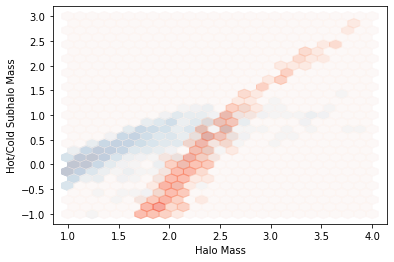

In [11]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
norm = LogNorm()
mask = (masses_h>0) & (masses[:,0]>0) & (masses[:,1]>0)
extent = [1,4,-1,3]
kwargs = dict(gridsize=25,alpha=0.5, norm=norm, extent=extent)
plt.hexbin(np.log10(masses_h[mask]), np.log10(masses[:,1][mask]), cmap="Blues", **kwargs)
plt.hexbin(np.log10(masses_h[mask]), np.log10(masses[:,0][mask]), cmap="Reds", **kwargs)
plt.xlabel("Halo Mass")
plt.ylabel("Hot/Cold Subhalo Mass")
plt.show()